<a href="https://colab.research.google.com/github/jaggernaut007/Image-Segmentation/blob/master/Virtual_Background.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### This notebook is optionally accelerated with a GPU runtime.
### If you would like to use this acceleration, please select the menu option "Runtime" -> "Change runtime type", select "Hardware Accelerator" -> "GPU" and click "SAVE"

----------------------------------------------------------------------

# Deeplabv3-ResNet101

*Author: Pytorch Team and AI Mage team*

(https://www.aimage.in)

**DeepLabV3 model with a ResNet-101 backbone**

In [167]:
import torch
model = torch.hub.load('pytorch/vision:v0.6.0', 'deeplabv3_resnet101', pretrained=True)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

All pre-trained models expect input images normalized in the same way,
i.e. mini-batches of 3-channel RGB images of shape `(N, 3, H, W)`, where `N` is the number of images, `H` and `W` are expected to be at least `224` pixels.
The images have to be loaded in to a range of `[0, 1]` and then normalized using `mean = [0.485, 0.456, 0.406]`
and `std = [0.229, 0.224, 0.225]`.

The model returns an `OrderedDict` with two Tensors that are of the same height and width as the input Tensor, but with 21 classes.
`output['out']` contains the semantic masks, and `output['aux']` contains the auxillary loss values per-pixel. In inference mode, `output['aux']` is not useful.
So, `output['out']` is of shape `(N, 21, H, W)`. More documentation can be found [here](https://pytorch.org/docs/stable/torchvision/models.html#object-detection-instance-segmentation-and-person-keypoint-detection).

In [0]:
# Download an example image from the pytorch website
import urllib
url, filename = ("https://tvguide1.cbsistatic.com/i/r/2018/02/10/3a534e4d-ffa5-402d-b68d-cb0c7368e6af/thumbnail/1300x867/484fb3fb0611a3cbafb8dc62d26bdcd1/180209-personofinterest.jpg", "dog.jpg")
try: urllib.URLopener().retrieve(url, filename)
except: urllib.request.urlretrieve(url, filename)

In [0]:
url2, filename2 = ("https://i.ytimg.com/vi/cdWj8fXHQLg/maxresdefault.jpg", "space.jpg")
try: urllib.URLopener().retrieve(url2, filename2)
except: urllib.request.urlretrieve(url2, filename2)

In [170]:
input_image = Image.open(filename)
bgImage = Image.open("space.jpg")
input_image =input_image.resize(im2.size)
input_image.size

(1280, 720)

In [0]:
# sample execution (requires torchvision)
from PIL import Image
from PIL import ImageDraw
from torchvision import transforms
input_image = Image.open(filename)
im2 = Image.open("space.jpg")
input_image =input_image.resize(im2.size)
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

# move the input and model to GPU for speed if available
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model.to('cuda')

with torch.no_grad():
    output = model(input_batch)['out'][0]
output_predictions = output.argmax(0)

The output here is of shape `(21, H, W)`, and at each location, there are unnormalized proababilities corresponding to the prediction of each class.
To get the maximum prediction of each class, and then use it for a downstream task, you can do `output_predictions = output.argmax(0)`.

Here's a small snippet that plots the predictions, with each color being assigned to each class (see the visualized image on the left).

In [0]:
import numpy as np
#map person to index
LABEL_NAMES = np.asarray([
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
])

size = 720, 720
r.thumbnail(size, Image.ANTIALIAS)
input_image.thumbnail(size, Image.ANTIALIAS)
bgImage.thumbnail(size, Image.ANTIALIAS)

r_np = np.asarray(r)
img_np = np.asarray(input_image)
bgImage_np =np.array(im2)
bgImage_np.setflags(write=1)

In [178]:
print(r_np.shape,img_np.shape,bgImage_np.shape)

(405, 720) (405, 720, 3) (405, 720, 3)


In [0]:
#Super impose person on Bakground image
for i in range(r_np.shape[0]):
  for j in range(r_np.shape[1]):
    if(r_np[i][j]==15):
      bgImage_np[i][j] = img_np[i][j]

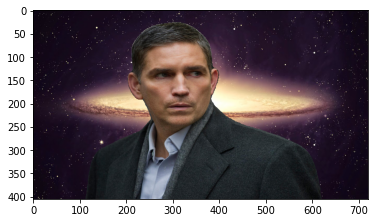

In [180]:
#Convert Numpy to image
virtualBG = Image.fromarray(bgImage_np)
#Show Image
import matplotlib.pyplot as plt
plt.imshow(virtualBG)

### Model Description

Deeplabv3-ResNet101 is contructed by a Deeplabv3 model with a ResNet-101 backbone.
The pre-trained model has been trained on a subset of COCO train2017, on the 20 categories that are present in the Pascal VOC dataset.

Their accuracies of the pre-trained models evaluated on COCO val2017 dataset are listed below.

|    Model structure  |   Mean IOU  | Global Pixelwise Accuracy |
| ------------------- | ----------- | --------------------------|
| deeplabv3_resnet101 |   67.4      |   92.4                    |

### Resources

 - [Rethinking Atrous Convolution for Semantic Image Segmentation](https://arxiv.org/abs/1706.05587)